In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.transform import resize

np.random.seed(42)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/jonathanglima/.virtualenvs/ml/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def get_triplets(x, y, batch_size=100, image_size=(225, 225)):
    z = list(zip(x, y))

    random.shuffle(z)

    x, y = zip(*z[:batch_size])

    return [(resize(x[k], image_size), resize(x[np.random.choice(np.where(y != y_)[0], 1)[0]], image_size),
             resize(x[np.random.choice(np.delete(np.where(y == y_)[0], np.argwhere(np.where(y == y_)[0]==k)), 1)[0]], image_size))
            for k, y_ in enumerate(y)]


In [3]:
triplets = get_triplets(x_train, y_train)

/Users/jonathanglima/.virtualenvs/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


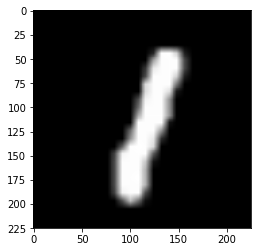

In [4]:
plt.imshow(triplets[0][0], cmap='gray')
plt.show()

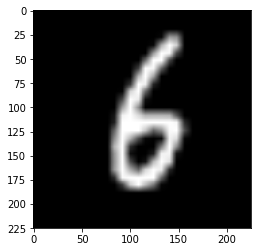

In [5]:
plt.imshow(triplets[0][1], cmap='gray')
plt.show()

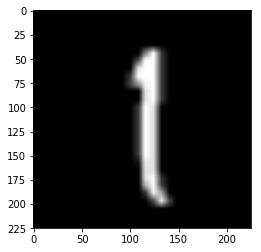

In [6]:
plt.imshow(triplets[0][2], cmap='gray')
plt.show()

In [7]:
import keras.backend as K
from keras.layers import *
from keras.models import Model

width = 225
height = 225
depth = 1

p_i = Input(shape=(width, height, depth), dtype='float32', name='p_input')
pi_n = Input(shape=(width, height, depth), dtype='float32', name='p_negative_input')
pi_p = Input(shape=(width, height, depth), dtype='float32', name='p_positive_input')

def generate_convnet(input_layer):
    conv2d_1 = Conv2D(96, (5,5), strides=(2,2), activation=K.relu)(input_layer)
    norm_1 = normalization.BatchNormalization()(conv2d_1)
    max_pool_1 = MaxPooling2D(pool_size=(2,2))(norm_1)

    conv2d_2 = Conv2D(256, (5,5), strides=(2,2), activation=K.relu)(max_pool_1)
    norm_2 = normalization.BatchNormalization()(conv2d_2)
    max_pool_2 = MaxPooling2D(pool_size=(2,2))(norm_2)

    conv2d_3 = Conv2D(384, (2,2), strides=(1,1), activation=K.relu)(max_pool_2)
    
    conv2d_4 = Conv2D(384, (2,2), strides=(1,1), activation=K.relu)(conv2d_3)
    
    conv2d_5 = Conv2D(256, (2,2), strides=(1,1), activation=K.relu)(conv2d_4)
    max_pool_5 = MaxPooling2D(pool_size=(2,2))(conv2d_2)
    flat_5 = Reshape((43264,))(max_pool_5)
    
    dense_6 = Dense(4096)(flat_5)
    dropout_6 = Dropout(0.6)(dense_6)
    
    dense_7 = Dense(4096)(dropout_6)
    dropout_7 = Dropout(0.6)(dense_7)
    
    l2_norm = Lambda(lambda  x: K.l2_normalize(x,axis=-1))(dropout_7)
    return l2_norm

def generate_bigger_sampling(input_layer):
    sub_sampling = AveragePooling2D((4, 4))(input_layer)
    conv2d = Conv2D(96, (14, 14), strides=(3,3), activation=K.relu)(sub_sampling)
    return MaxPooling2D(pool_size=(6,6), strides=(3,3))(conv2d)

def generate_smaller_sampling(input_layer):
    sub_sampling = AveragePooling2D((8, 8))(input_layer)
    conv2d = Conv2D(96, (7, 7), strides=(3, 3), activation=K.relu)(sub_sampling)
    return MaxPooling2D(pool_size=(5,5), strides=(1,1))(conv2d)

def generate_middle_layers(input_layer):
    conv_net = generate_convnet(input_layer)
    bigger = generate_bigger_sampling(input_layer)
    smaller = generate_smaller_sampling(input_layer)
    
    merge_1 = concatenate([bigger, smaller])
    l2_norm_1 = Lambda(lambda  x: K.l2_normalize(x,axis=-1))(merge_1)
    flat = Reshape((3072,))(l2_norm_1)
    
    merge_2 = concatenate([conv_net, flat])
    linear_embedding = Embedding(4096 ,4096)(merge_2)
    l2_norm_2 = Lambda(lambda  x: K.l2_normalize(x,axis=-1))(linear_embedding)
    return l2_norm_2

def generate_whole_architecture(p_of_i, p_of_i_neg, p_of_i_pos):
    i_middle = generate_middle_layers(p_of_i)
    i_middle_neg = generate_middle_layers(p_of_i_neg)
    i_middle_pos = generate_middle_layers(p_of_i_pos)
    
    l2_norm_1 = Lambda(lambda  x: K.l2_normalize(x,axis=-1))(merge_1)
    
    model = Model(inputs=p_of_i, outputs=i_middle)
    model.summary()
    


In [8]:
generate_whole_architecture(p_i, pi_n, pi_p)

NameError: name 'merge_1' is not defined